In [8]:
import numpy as np
import random
from matplotlib import pyplot as plt
import pandas as pd

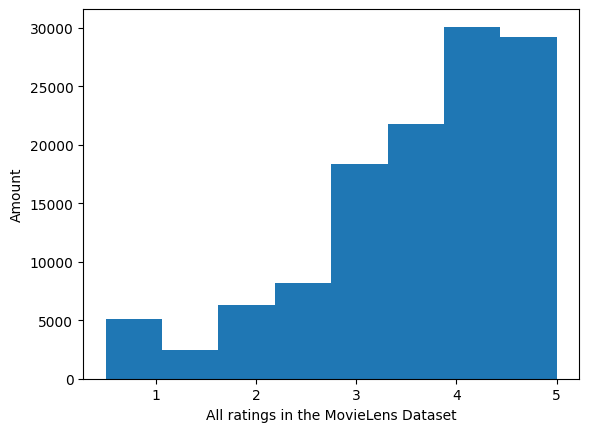

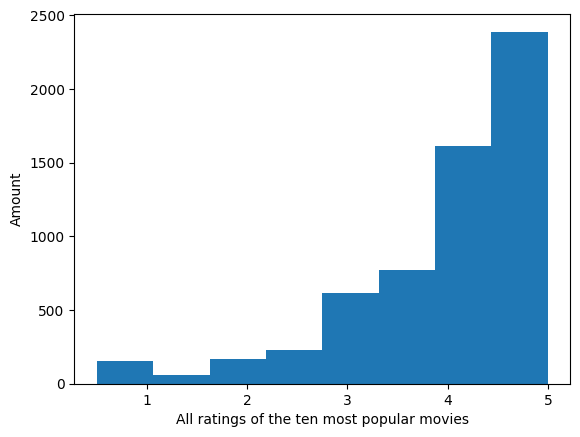

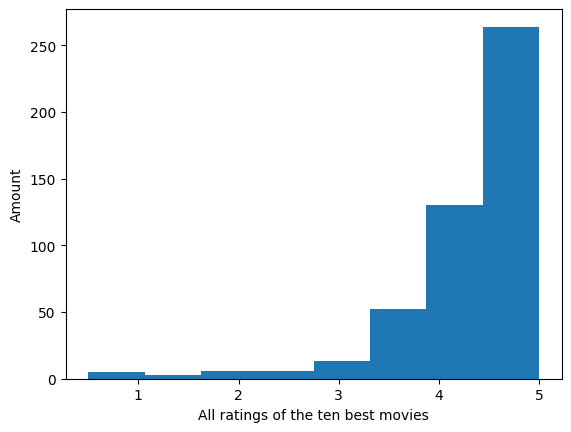

In [9]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
data = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv")

# all ratings in the movielens dataset
all_ratings = data['Rating'].values

plt.figure()
plt.hist(all_ratings, bins=8)
plt.xlabel("All ratings in the MovieLens Dataset")
plt.ylabel("Amount")
plt.show()

# top 10
ten_most_popular = data['Movie ID'].value_counts().index[:10]
ten_most_popular_ratings = data[data['Movie ID'].isin(ten_most_popular)]['Rating'].values
plt.figure()
plt.hist(ten_most_popular_ratings, bins=8)
plt.xlabel("All ratings of the ten most popular movies")
plt.ylabel("Amount")
plt.show()


# movies with highest average raitngs
ten_best = data.groupby('Movie ID')['Rating'].mean().sort_values(ascending=False).index[:10]
ten_best_ratings = data[data['Movie ID'].isin(ten_best)]['Rating'].values
plt.figure()
plt.hist(ten_best_ratings, bins=8)
plt.xlabel("All ratings of the ten best movies")
plt.ylabel("Amount")
plt.show()

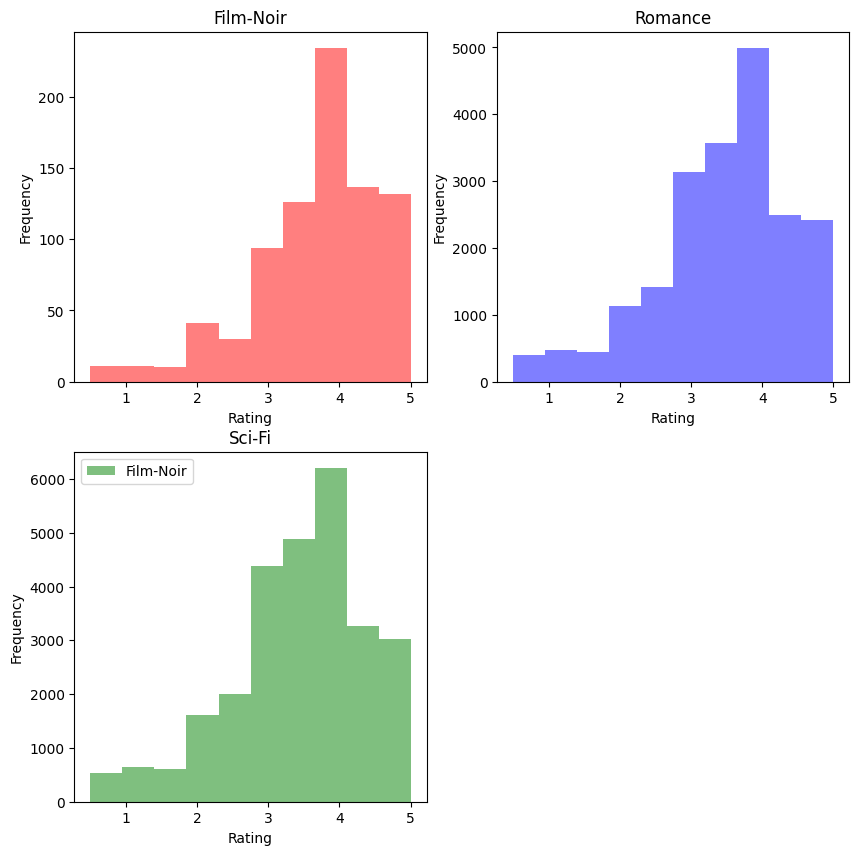

In [10]:
# all ratings of movies from three grenres of your choice

film_noir = movies[movies['Film-Noir'] == 1]['Movie ID'].values
ten_film_noir = data[data['Movie ID'].isin(film_noir)]['Rating'].values
plt.figure(figsize=(10, 10))
#  All ratings of movies from three genres of your choice (create three separate visualizations).
plt.subplot(2, 2, 1)
plt.hist(ten_film_noir, bins=10,   color='red', alpha=0.5)
plt.title('Film-Noir')
plt.xlabel('Rating')
plt.ylabel('Frequency')
romnace = movies[movies['Romance'] == 1]['Movie ID'].values
ten_romnace = data[data['Movie ID'].isin(romnace)]['Rating'].values
plt.subplot(2, 2, 2)
plt.hist(ten_romnace, bins=10,  color='blue', alpha=0.5)
plt.title('Romance')
plt.xlabel('Rating')
plt.ylabel('Frequency')
sci_fi = movies[movies['Sci-Fi'] == 1]['Movie ID'].values
ten_sci_fi = data[data['Movie ID'].isin(sci_fi)]['Rating'].values
plt.subplot(2, 2, 3)
plt.hist(ten_sci_fi, bins=10,  color='green', alpha=0.5)
plt.title('Sci-Fi')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [11]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    error = 0.5 * reg * np.linalg.norm(U)**2 +  np.linalg.norm(V)**2
    for i in range(len(Y)):
        error += 0.5 * (Y[i, 2] - np.dot(U[Y[i, 0] - 1], V[Y[i, 1] - 1]))**2
    return error/len(Y)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U, V = np.random.uniform(-0.5,0.5, (M, K)), np.random.uniform(-0.5,0.5, (N, K))
    init_err = get_err(U, V, Y, reg)
    e_t = 1
    e_dt = 1
    for epoch in range(max_epochs):
      perm = np.random.permutation(len(Y))
      err = get_err(U,V,Y,reg)
      for idx in perm:
        i, j, y = Y[idx][0], Y[idx][1], Y[idx][2]
        U[i-1] -= grad_U(U[i-1], y, V[j-1], reg, eta)
        V[j-1] -= grad_V(V[j-1], y, U[i-1], reg, eta)
      if epoch == 0:
        err_0 = get_err(U,V,Y,reg)
        e_t = err_0 - err
      else:
        err_i = get_err(U,V,Y,reg)
        e_dt = err_i - err
        if (e_t - e_dt)/ init_err <= eps:
          break
    return U, V, get_err(U,V,Y)


In [12]:

def split_data(data, m):
    # randomly shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    # split the data into training and test sets
    train = data[:m]
    test = data[m:]
    return train, test

train, test = split_data(data, 109351)
# print(type(train),type(test))
train = train.to_numpy().astype(int)
test = test.to_numpy().astype(int)
k = 20
# m,n be the number of users and movies
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies

nn = 0.02
# track accuracy via out_of_sample_error
E_out = 0
E_in = 0
U,V, E_in = train_model(M,N,k,nn,0.00,train)
E_out = get_err(U,V,test,0.00)
print("Our in sample error on the train data results in", E_in)
print("Our out of sample error on the test data results i:",E_out)
# getting a high E_out for some reason, not sure exactly why




Our in sample error on the train data results in 0.4362496875376039
Our out of sample error on the test data results i: 1.0504867128788093


In [17]:
A, sigma, B = np.linalg.svd(np.transpose(V))

V_2d = np.dot(np.transpose(A[:,:2]),np.transpose(V))
U_2d = np.dot(np.transpose(A[:,:2]),np.transpose(U))

[[-1.71041304 -1.13694921 -2.00676632 ... -1.60381083 -1.5188465
  -1.74609117]
 [ 0.14847439  0.03346605 -0.34524775 ...  0.01652697 -0.30414248
   0.09692606]] [[-1.6856084  -1.45196809 -2.28000694 ... -1.38648187 -1.64750347
  -1.9744245 ]
 [-0.60042163 -0.04575907 -0.19297573 ...  0.04945399 -0.04451969
   0.71279034]]


[[-1.90263558 -1.71097852 -1.3889281  -1.54729113 -1.27188557 -1.9652519
  -1.752578   -1.29103678 -1.73105459 -1.06194441]
 [-0.04813255  0.33827901  0.14212376 -0.35598997 -0.23306251 -0.21673654
   0.10341881  0.58385176 -0.2745058   0.30535817]]


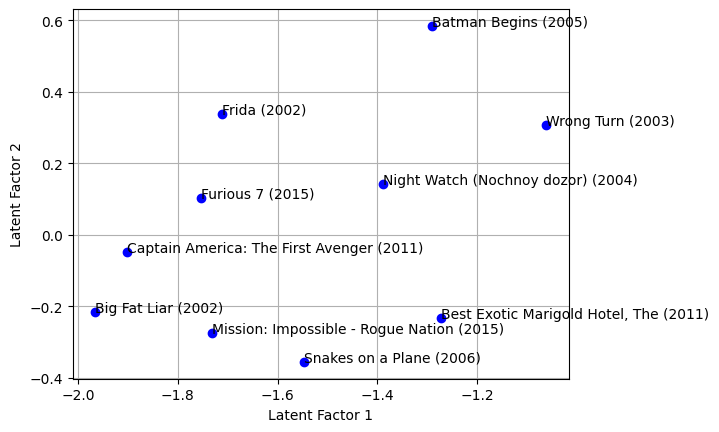

In [28]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
random_ten = [np.random.randint(0,len(movies)-1) for i in range(10)]
movie_list = np.array(movies)[:,1]
movie_list = movie_list[random_ten]
coordinates = V_2d[:,random_ten]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()


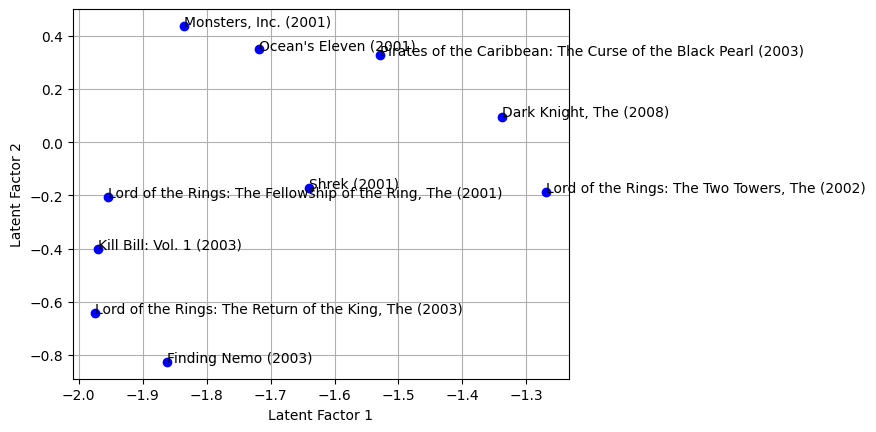

In [29]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
pop_ten = data['Movie ID'].value_counts().index[:10]
movie_list = np.array(movies)[:,1]
movie_list = movie_list[pop_ten]
coordinates = V_2d[:,pop_ten]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()



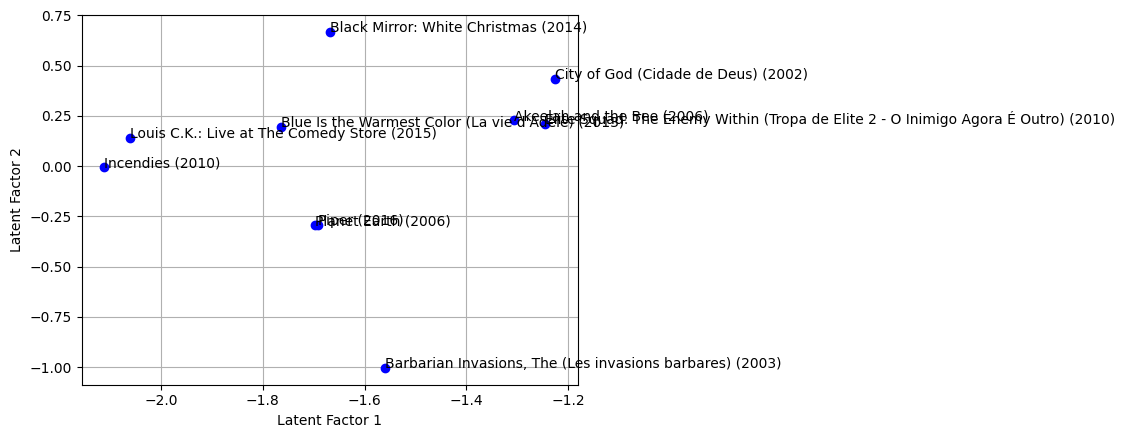

In [30]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
ten_best = data.groupby('Movie ID')['Rating'].mean().sort_values(ascending=False).index[:10]
movie_list = np.array(movies)[:,1]
movie_list = movie_list[ten_best]
coordinates = V_2d[:,ten_best]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()

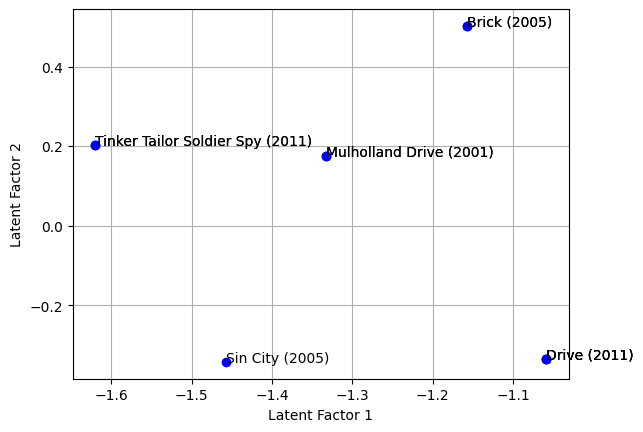

In [34]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
film_noir = movies[movies['Film-Noir'] == 1]['Movie ID'].values
random_noir = np.random.choice(film_noir,10)
movie_list = np.array(movies)[:,1]
movie_list = movie_list[random_noir]
coordinates = V_2d[:,random_noir]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()

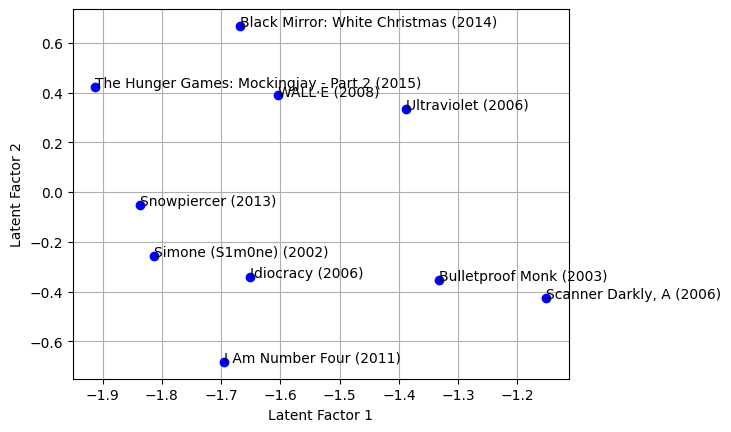

In [35]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
film_noir = movies[movies['Sci-Fi'] == 1]['Movie ID'].values
random_noir = np.random.choice(film_noir,10)
movie_list = np.array(movies)[:,1]
movie_list = movie_list[random_noir]
coordinates = V_2d[:,random_noir]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()

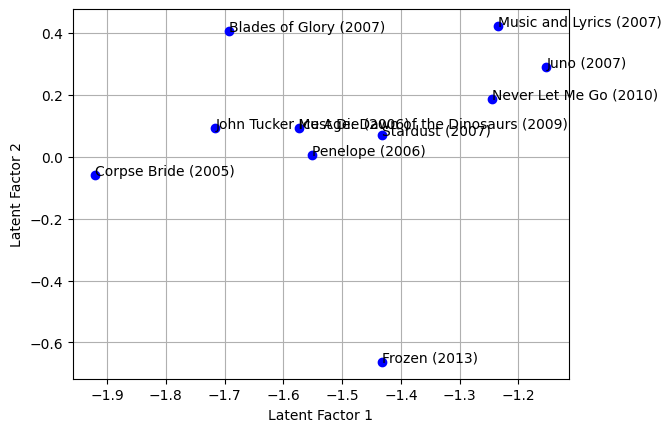

In [36]:
movies = pd.read_csv("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv")
film_noir = movies[movies['Romance'] == 1]['Movie ID'].values
random_noir = np.random.choice(film_noir,10)
movie_list = np.array(movies)[:,1]
movie_list = movie_list[random_noir]
coordinates = V_2d[:,random_noir]
plt.figure()
plt.grid()
plt.plot(coordinates[0,:], coordinates[1,:], "bo")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
for i,txt in enumerate(movie_list):
    plt.text(coordinates[0,i], coordinates[1,i],txt)
plt.show()